**Install and import dependencies**


In [28]:
from obspy import read
import numpy as np
from preprocessing import Seismic
import os

**Replace file_name with the path to the SEGY file in the Dixondale folder**

In [29]:
dixondale = "G:/3D Seismic Volumes-SEGY/Seismic Data 3DX/Dixondale/DixondalePSTM_8-14-19_filtered_export3.sgy"

netherlands = "./SeismicData/Netherlands.sgy"

stream = read(dixondale, format="SEGY")
stream.normalize()

seismicData = Seismic(stream)

c:\Users\PangD\Desktop\SeismicML\.venv\lib\site-packages\obspy\core\trace.py:2246: UserWarning: Attempting to normalize by dividing through zero. This is not allowed and the data will thus not be changed.
  warnings.warn(msg)


In [13]:
print(seismicData.seismic_array.shape)

(366, 343, 2000)


Text(0, 0.5, 'Depth')

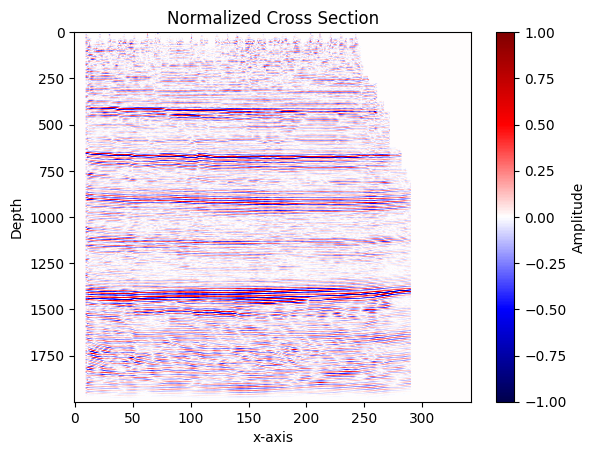

In [30]:
import matplotlib.pyplot as plt

img = np.flipud(np.rot90(seismicData.seismic_array[177]))

plt.imshow(img, cmap="seismic", aspect="auto")
plt.colorbar(label="Amplitude")
plt.title("Normalized Cross Section")
plt.xlabel("x-axis")
plt.ylabel("Depth")

In [34]:
faults_location = "G:/3D Seismic Volumes-SEGY/Dixondale/Faults Exported/"


faults_only = np.zeros(seismicData.seismic_array.shape)


for i in os.listdir(faults_location):
    faultstr = open(faults_location+i, "r").read()
    faultCoords = seismicData.get_fault_indexes(faultstr)
    for coord in faultCoords:
        try:
            faults_only[coord[0]][coord[1]][coord[2]] = seismicData.seismic_array[coord[0]][coord[1]][coord[2]]
        except:
            print(coord)
            break


(158, 247, 199233)
(103, 341, 199172)


In [47]:
print(faults_only)

[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 ...

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]


**Convert into Numpy array with axes as (depth, crossline, inline)**

**Plot the cross section in the middle of the cube**

In [48]:
import torch
import warnings

if not torch.cuda.is_available():
    warnings.warn("No hardware acceleration is being used. Install CUDA for better model training")
else:
    print("Torch with CUDA is enabled")


Torch with CUDA is enabled


In [58]:
import torch.nn as nn
import torch.optim as optim
from preprocessing import pad_or_crop_3d_array

class FaultExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.lstm = nn.LSTM(input_size=64, hidden_size=128, num_layers=1, batch_first=True)
        self.fc = nn.Linear(128, 1)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = x.view(x.size(0), x.size(1), -1)  # Flatten the spatial dimensions
        lstm_out, _ = self.lstm(x)
        output = torch.sigmoid(self.fc(lstm_out[:, -1, :]))  # Taking the output from the last LSTM step
        return output
        

In [63]:
model = FaultExtractor()
model.cuda()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

seismic_data_tensor = torch.tensor(seismicData.seismic_array[0], dtype=torch.float32).cuda()


print(seismic_data_tensor)

outputs = model(seismic_data_tensor)
print(outputs)


'''
num_epochs = 10
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(seismic_data_tensor)
    loss = criterion(outputs, target_fault_lines_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print loss
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item()}')
'''

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]], device='cuda:0')


RuntimeError: shape '[1024000, 1]' is invalid for input of size 32768